# **Machine Learning on Big Data (CN7030) CRWK 23-24 Term B [60% weighting]**
# **Group ID: [Group13]**
1.   Student 1: Philip Acquaye-Mensah 2640756
2.   Student 2: Mohamed Jareer MOHAMED  ZEENAM 2596353

---

If you want to add comments on your group work, please write it here for us:


# **Initiate and Configure Spark**

In [130]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler, MinMaxScaler, RobustScaler, Imputer
from pyspark.ml.classification import LogisticRegression, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.regression import LinearRegression


# Initialize SparkSession
spark = SparkSession.builder \
                    .appName("Group 13 CRWK") \
                    .master("local[*]") \
                    .config("spark.executor.memory", "4g") \
                    .config("spark.driver.memory", "2g") \
                    .config("spark.executor.cores", "2") \
                    .config("spark.sql.inMemoryColumnarStorage.compressed", "true") \
                    .getOrCreate()


---
# **Task 1 - Data Loading and Preprocessing (15 marks)**
---

In [131]:
#Identify the student who made a contribution and mention their name in the appropriate section of the code.

## Philip Acquaye-Mensah

# Load the compressed file as a text file
df = spark.read.csv("CourseWork_Dataset_Machine_Learning.csv", header = True)
# Display the DataFrame
df.show(20, truncate= False)

# more info
print(df.count(), df.rdd.getNumPartitions())

+--------+--------+-------------------+-------------+------------+------------+---------------+---------------+---------------+---------------+----------------+---------------+---------------+---------------+----------------+---------------+-----------+-----------+-------------+------------+------------+------------+-----------+------------+-----------+-----------+-----------+-----------+------------+-----------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+-----------+-----------+-----------+-----------+------------+-----------+-----------+------------+------------+------------+------------+------------+------------+--------------+------------+-------------+------------+----------------+----------------+--------------+--------------+----------------+--------------+--------------+----------------+----------------+----------------+----------------+----------------+-----------------+-----------------+-----------------+------

In [132]:
from pyspark.sql.functions import col
from pyspark.sql.types import FloatType

# Exclude 'Label' column from casting
columns_to_cast = [column for column in df.columns if column != 'Label']

for column in columns_to_cast:
    new_column = column.replace(' ', '_').replace('/', '_per_')
    df = df.withColumnRenamed(column, new_column).withColumn(new_column, col(new_column).cast(FloatType()))

In [133]:
# Check Multi class label
# Label is the column named Label
df.select("Label").distinct().show(20)

+--------------+
|         Label|
+--------------+
|        Benign|
|FTP-BruteForce|
|SSH-Bruteforce|
+--------------+



In [134]:
from pyspark.sql.functions import when, col

# Convert "Label" into a binary classification where "Benign" is 0 and any attack is 1
df = df.withColumn("Label_binary", when(col("Label") == "Benign", 0).otherwise(1))

# Display the updated DataFrame to verify the transformation
df.select("Label", "Label_binary").distinct().show()

+--------------+------------+
|         Label|Label_binary|
+--------------+------------+
|FTP-BruteForce|           1|
|        Benign|           0|
|SSH-Bruteforce|           1|
+--------------+------------+



In [135]:
# Drop Label column because of new binary label and Timestamp column
df = df.drop("Label","Timestamp")

# Print the schema to see the data types and structure
df.printSchema()

root
 |-- Dst_Port: float (nullable = true)
 |-- Protocol: float (nullable = true)
 |-- Flow_Duration: float (nullable = true)
 |-- Tot_Fwd_Pkts: float (nullable = true)
 |-- Tot_Bwd_Pkts: float (nullable = true)
 |-- TotLen_Fwd_Pkts: float (nullable = true)
 |-- TotLen_Bwd_Pkts: float (nullable = true)
 |-- Fwd_Pkt_Len_Max: float (nullable = true)
 |-- Fwd_Pkt_Len_Min: float (nullable = true)
 |-- Fwd_Pkt_Len_Mean: float (nullable = true)
 |-- Fwd_Pkt_Len_Std: float (nullable = true)
 |-- Bwd_Pkt_Len_Max: float (nullable = true)
 |-- Bwd_Pkt_Len_Min: float (nullable = true)
 |-- Bwd_Pkt_Len_Mean: float (nullable = true)
 |-- Bwd_Pkt_Len_Std: float (nullable = true)
 |-- Flow_Byts_per_s: float (nullable = true)
 |-- Flow_Pkts_per_s: float (nullable = true)
 |-- Flow_IAT_Mean: float (nullable = true)
 |-- Flow_IAT_Std: float (nullable = true)
 |-- Flow_IAT_Max: float (nullable = true)
 |-- Flow_IAT_Min: float (nullable = true)
 |-- Fwd_IAT_Tot: float (nullable = true)
 |-- Fwd_IAT_Mean:

In [136]:
# Check for how many attacks and benign
df.groupBy("Label_binary").count().show()

+------------+------+
|Label_binary| count|
+------------+------+
|           1|380949|
|           0|667626|
+------------+------+



In [137]:
# Check for missing values in each column
from pyspark.sql.functions import isnan, when, count, col
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+--------+--------+-------------+------------+------------+---------------+---------------+---------------+---------------+----------------+---------------+---------------+---------------+----------------+---------------+---------------+---------------+-------------+------------+------------+------------+-----------+------------+-----------+-----------+-----------+-----------+------------+-----------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+--------------+--------------+-----------+-----------+------------+-----------+-----------+------------+------------+------------+------------+------------+------------+--------------+------------+-----------------+------------+----------------+----------------+------------------+------------------+----------------+------------------+------------------+----------------+----------------+----------------+----------------+----------------+-----------------+-----------------+----------

In [138]:
from pyspark.sql.functions import col
from pyspark.sql.types import FloatType


# Now, use the Imputer on the renamed column
imputer = Imputer(
    inputCols=["Flow_Byts_per_s"],
    outputCols=["Flow_Byts_s_imputed"]
).setStrategy("median")

df = imputer.fit(df).transform(df)

# Drop the 'Flow_Byts_per_s' column
df = df.drop('Flow_Byts_per_s')

# Print Schema again to check the changes
df.printSchema()

root
 |-- Dst_Port: float (nullable = true)
 |-- Protocol: float (nullable = true)
 |-- Flow_Duration: float (nullable = true)
 |-- Tot_Fwd_Pkts: float (nullable = true)
 |-- Tot_Bwd_Pkts: float (nullable = true)
 |-- TotLen_Fwd_Pkts: float (nullable = true)
 |-- TotLen_Bwd_Pkts: float (nullable = true)
 |-- Fwd_Pkt_Len_Max: float (nullable = true)
 |-- Fwd_Pkt_Len_Min: float (nullable = true)
 |-- Fwd_Pkt_Len_Mean: float (nullable = true)
 |-- Fwd_Pkt_Len_Std: float (nullable = true)
 |-- Bwd_Pkt_Len_Max: float (nullable = true)
 |-- Bwd_Pkt_Len_Min: float (nullable = true)
 |-- Bwd_Pkt_Len_Mean: float (nullable = true)
 |-- Bwd_Pkt_Len_Std: float (nullable = true)
 |-- Flow_Pkts_per_s: float (nullable = true)
 |-- Flow_IAT_Mean: float (nullable = true)
 |-- Flow_IAT_Std: float (nullable = true)
 |-- Flow_IAT_Max: float (nullable = true)
 |-- Flow_IAT_Min: float (nullable = true)
 |-- Fwd_IAT_Tot: float (nullable = true)
 |-- Fwd_IAT_Mean: float (nullable = true)
 |-- Fwd_IAT_Std: flo

In [139]:
df.describe("Flow_Pkts_per_s").show(10)

+-------+---------------+
|summary|Flow_Pkts_per_s|
+-------+---------------+
|  count|        1048575|
|   mean|       Infinity|
| stddev|            NaN|
|    min|   -0.001029761|
|    max|       Infinity|
+-------+---------------+



In [140]:
from pyspark.sql.functions import col, isnan
 
# Iterate through each column in the DataFrame
for column in df.columns:
    # Filter and count rows with null values
    null_count = df.filter(col(column).isNull()).count()
    if null_count > 0:
        print(f"Column '{column}' has {null_count} rows with null values.")
    # Filter and count rows with NaN values
    nan_count = df.filter(isnan(col(column))).count()
    if nan_count > 0:
        print(f"Column '{column}' has {nan_count} rows with NaN values.")
    # Filter and count rows with negative values
    negative_count = df.filter(col(column) < 0).count()
    if negative_count > 0:
        print(f"Column '{column}' has {negative_count} rows with negative values.")
        
    # Filter and count rows with infinity values
    infinity_count = df.filter(col(column) == float('inf')).count()
    if infinity_count > 0:
        print(f"Column '{column}' has {infinity_count} rows with infinity values.")


Column 'Flow_Duration' has 5 rows with negative values.
Column 'Flow_Pkts_per_s' has 5 rows with negative values.
Column 'Flow_Pkts_per_s' has 3824 rows with infinity values.
Column 'Flow_IAT_Mean' has 5 rows with negative values.
Column 'Flow_IAT_Max' has 2 rows with negative values.
Column 'Flow_IAT_Min' has 5 rows with negative values.
Column 'Fwd_IAT_Tot' has 5 rows with negative values.
Column 'Fwd_IAT_Mean' has 5 rows with negative values.
Column 'Fwd_IAT_Max' has 2 rows with negative values.
Column 'Fwd_IAT_Min' has 5 rows with negative values.
Column 'Init_Fwd_Win_Byts' has 219266 rows with negative values.
Column 'Init_Bwd_Win_Byts' has 347370 rows with negative values.
Column 'Flow_Byts_s_imputed' has 1547 rows with infinity values.


In [141]:
from pyspark.sql.functions import when, col

# List of columns to replace Infinity values with NaN
columns = ["Flow_Byts_s_imputed", "Flow_Pkts_per_s"]

#! Loop through each column and replace Infinity with NaN
for col_name in columns:
    df = df.withColumn(col_name, when(col(col_name) == float('inf'), float('nan')).otherwise(col(col_name)))
    
#! Replace negative values with zero for all columns in the DataFrame
for col_name in df.columns:
    df = df.withColumn(col_name, when(df[col_name] < 0, 0).otherwise(df[col_name]))


output_cols = ["Flow_Byts_s_nan_imputed", "Flow_Pkts_per_s_nan_imputed"]


#! impute nan values with mean
imputer = Imputer(
    inputCols=columns,
    outputCols=output_cols
).setStrategy("median")



df = imputer.fit(df).transform(df)

df.describe("Flow_Byts_s_nan_imputed").show()

+-------+-----------------------+
|summary|Flow_Byts_s_nan_imputed|
+-------+-----------------------+
|  count|                1048575|
|   mean|     193096.85716243155|
| stddev|      3096074.866298894|
|    min|                    0.0|
|    max|           4.45249984E8|
+-------+-----------------------+



In [142]:
df = df.drop('Flow_Byts_s_imputed', 'Flow_Pkts_per_s')

df.show(10, truncate=False)

+--------+--------+-------------+------------+------------+---------------+---------------+---------------+---------------+----------------+---------------+---------------+---------------+----------------+---------------+-------------+------------+------------+------------+------------+------------+-----------+-----------+-----------+-----------+------------+-----------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+--------------+--------------+-----------+-----------+------------+-----------+-----------+------------+------------+------------+------------+------------+------------+--------------+------------+-----------------+------------+----------------+----------------+------------------+------------------+----------------+------------------+------------------+----------------+----------------+----------------+----------------+----------------+-----------------+-----------------+-----------------+----------------+------

In [143]:
# Check for missing values again
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+--------+--------+-------------+------------+------------+---------------+---------------+---------------+---------------+----------------+---------------+---------------+---------------+----------------+---------------+-------------+------------+------------+------------+-----------+------------+-----------+-----------+-----------+-----------+------------+-----------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+--------------+--------------+-----------+-----------+------------+-----------+-----------+------------+------------+------------+------------+------------+------------+--------------+------------+-----------------+------------+----------------+----------------+------------------+------------------+----------------+------------------+------------------+----------------+----------------+----------------+----------------+----------------+-----------------+-----------------+-----------------+----------------+-------

In [144]:
# VectorAssembler and the rest of the pipeline
from pyspark.ml.feature import VectorAssembler

feature_columns = [column for column in df.columns if column not in ['Label_binary']]  # Exclude the target column

vectorAssembler = VectorAssembler(inputCols=feature_columns, outputCol="features") # VectorAssembler

data = vectorAssembler.transform(df) # Transform the DataFrame

data = data.select('features', 'Label_binary')
data.show(5)


+--------------------+------------+
|            features|Label_binary|
+--------------------+------------+
|(78,[2,3,15,16,17...|           0|
|(78,[2,3,15,16,17...|           0|
|(78,[2,3,15,16,17...|           0|
|(78,[0,1,2,3,4,5,...|           0|
|(78,[0,1,2,3,4,5,...|           0|
+--------------------+------------+
only showing top 5 rows



In [145]:
# Check again for any null or NaN values that might have been introduced
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+--------+--------+-------------+------------+------------+---------------+---------------+---------------+---------------+----------------+---------------+---------------+---------------+----------------+---------------+-------------+------------+------------+------------+-----------+------------+-----------+-----------+-----------+-----------+------------+-----------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+--------------+--------------+-----------+-----------+------------+-----------+-----------+------------+------------+------------+------------+------------+------------+--------------+------------+-----------------+------------+----------------+----------------+------------------+------------------+----------------+------------------+------------------+----------------+----------------+----------------+----------------+----------------+-----------------+-----------------+-----------------+----------------+-------

In [146]:
# Sparse Vectors
data.show(10, truncate = False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------+
|features                                                                                                                                                                                                                                                                                                                          

In [147]:
# Extract the values from Sparse Vectors to the list format
data_select = data.select('features').limit(2).collect()
for val in data_select:
    dense_vector = val[0].toArray()
    print(dense_vector)

[0.00000000e+00 0.00000000e+00 1.12641720e+08 3.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.63208600e+07
 1.39300034e+02 5.63209600e+07 5.63207600e+07 1.12641720e+08
 5.63208600e+07 1.39300034e+02 5.63209600e+07 5.63207600e+07
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.66331155e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

### StandardScaler

In [148]:
# Normalizing feature vectors
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
scaler_model = scaler.fit(data)
data = scaler_model.transform(data)

data = data.select("scaledFeatures", "Label_binary")
data.show(3, truncate = False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------+
|scaledFeatures                                                                                                                                                                                                                                                                                                                                                                                                              |Label_binary|
+-----------------------------------------------------------------------------------------------------------------------------------------------

In [149]:
# Split the data into training and testing sets
train_data, test_data = data.randomSplit([0.7, 0.3], seed = 42)

train_data.printSchema()

root
 |-- scaledFeatures: vector (nullable = true)
 |-- Label_binary: integer (nullable = false)



In [150]:
train_data.show(2, truncate = False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------+
|scaledFeatures                                                                                                                                                  

In [151]:
#! Double check for any Negative, Infinity or NaN values

# Iterate through each column in the DataFrame
for column in df.columns:
    # Filter rows where the column contains problematic values
    problematic_rows = df.filter(
        (col(column).isNull()) |   # Check for null values
        (isnan(col(column))) |     # Check for NaN values
        (col(column) < 0) |        # Check for negative values
        (col(column) == float('inf'))  # Check for infinity values
    )
    
    # If there are any rows containing problematic values, print the column name
    if problematic_rows.count() > 0:
        print(f"Column '{column}' has {problematic_rows.count()} rows with problematic values.")

---
# **Task 2 - Model Selection and Implementation (25 marks)**
---


### 1st student name: Philip Acquaye-Mensah
Model: Logistic Regression

In [152]:
# Apply Logistic Regression
lr = LogisticRegression(featuresCol = "scaledFeatures", labelCol = 'Label_binary', threshold = 0.5, regParam = 0.01)

lr_model = lr.fit(train_data)

lr_predictions_train = lr_model.transform(train_data)
lr_predictions_test = lr_model.transform(test_data)




In [153]:
lr_predictions_test.select("Label_binary", "prediction").show(20) 

+------------+----------+
|Label_binary|prediction|
+------------+----------+
|           0|       0.0|
|           0|       1.0|
|           0|       1.0|
|           0|       0.0|
|           0|       0.0|
|           0|       0.0|
|           0|       0.0|
|           0|       0.0|
|           0|       0.0|
|           0|       0.0|
|           0|       0.0|
|           0|       0.0|
|           0|       0.0|
|           0|       0.0|
|           0|       0.0|
|           0|       0.0|
|           0|       0.0|
|           0|       0.0|
|           0|       0.0|
|           0|       0.0|
+------------+----------+
only showing top 20 rows



In [154]:
# Check for accuracy
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Evaluate AUC (Area Under ROC)
auc_evaluator = BinaryClassificationEvaluator(
    labelCol="Label_binary",
    rawPredictionCol="rawPrediction",  # ensure logistic regression is configured to provide rawPrediction
    metricName="areaUnderROC"
)
auc = auc_evaluator.evaluate(lr_predictions_test)
print("Area Under ROC = %g" % auc)
print("Area Under ROC : " , round(auc, 5)*100)

# Evaluate AUPRC (Area Under Precision-Recall Curve)
pr_evaluator = BinaryClassificationEvaluator(
    labelCol="Label_binary",
    rawPredictionCol="rawPrediction",  # ensure logistic regression is configured to provide rawPrediction
    metricName="areaUnderPR"
)
pr = pr_evaluator.evaluate(lr_predictions_test)
print("Area Under PR = %g" % auc)
print("Area Under PR = ",  round(pr, 5)*100)



Area Under ROC = 0.99992
Area Under ROC :  99.992
Area Under PR = 0.99992
Area Under PR =  99.973


#### 2nd Student name: Mohamed Jareer Mohamed Zeenam
Model: Naive Bayes model

In [155]:
# Apply Naive Bayes Classifier

from pyspark.ml.classification import NaiveBayes

# Initialize Naive Bayes model
nb = NaiveBayes(featuresCol='scaledFeatures', labelCol='Label_binary', smoothing=0.5)  

# Fit the model to the training data
nb_model = nb.fit(train_data)

# Make predictions on the test data
nb_predictions = nb_model.transform(test_data)

In [156]:
# 2nd student name: Mohamed Jareer Mohamed Zeenam

nb_predictions.select('Label_binary', 'prediction').distinct().show()

+------------+----------+
|Label_binary|prediction|
+------------+----------+
|           0|       0.0|
|           1|       1.0|
|           1|       0.0|
|           0|       1.0|
+------------+----------+



---
# **Task 3 - Model Parameter Tuning (20 marks)**
---


In [157]:
# Common Evaluation Metrics for Binary Classification

from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Define the evaluator for binary classification
evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='Label_binary', metricName='areaUnderROC')

In [158]:
##1st student name: Philip Acquaye-Mensah
# perform grid search to find the best hyperparameters for the lr model 
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = (ParamGridBuilder()
                .addGrid(lr.regParam, [0.01, 0.5, 2.0])
                .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
                .addGrid(lr.maxIter, [1, 5, 10])
                .build())

# Create 5-fold CrossValidator
cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

# Run cross validations
cvModel = cv.fit(train_data)

# Use test set here so we can measure the accuracy of our model on new data
lr_predictions = cvModel.transform(test_data)

# cvModel uses the best model found from the Cross Validation
# Evaluate best model
evaluator.evaluate(lr_predictions)

# Print the coefficients and intercept for logistic regression
print("Coefficients: " + str(cvModel.bestModel.coefficients))
print("Intercept: " + str(cvModel.bestModel.intercept))

# Print the AUC for the test set
print("AUC: ", evaluator.evaluate(lr_predictions))

Coefficients: [-0.8390770699564187,-0.10707416229893393,-0.20845586978565947,0.03485919531175509,-0.04796540651408978,-0.0986706567391577,-0.08745118395671157,0.39982797998454805,-0.10241755212771644,-0.15779577402153197,-0.10495719058829117,0.2402416760279699,-0.08291570748907824,-0.2021849286591851,-0.10374911136061918,-0.09051734209781499,-0.0013116104894625058,-0.002886194860848893,-0.05360499694714134,-0.172764216852063,-0.08998743518872297,-0.0007154146695652705,-0.0019181147387225036,-0.054524192580072836,-0.19545068168356627,-0.23690918171110695,-0.22595591302726123,-0.18601020131269125,-0.05124696224648946,-0.09668571212816923,0.0,0.0,0.0,0.14195381424932826,0.008705386523937564,0.28125916371219783,0.6237389084323778,-0.0884054831390409,0.17807504363324866,-0.16878735618866608,-0.13050608294164107,-0.13333485776608434,-0.07012179702229275,-0.09668571212816923,-0.10444489663499983,0.14352635165308497,-0.06755737937981705,0.8736532823230051,0.0,-0.10443957440926155,0.32565549078

In [159]:
# 2nd student name: Mohamed Jareer Mohamed Zeenam
# Grid Search results for Naive Bayes

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Initialize Naive Bayes model
nb = NaiveBayes(featuresCol='scaledFeatures', labelCol='Label_binary')

# Define a grid of hyperparameters to search over
param_grid = ParamGridBuilder() \
              .addGrid(nb.smoothing, [0.1, 0.15, 0.2, 0.27, 0.3, 0.33, 0.4, 0.48, 0.5, 0.6, 0.7, 0.72, 0.76, 0.8, 0.9, 1]) \
              .build()

# Define cross-validation
crossval = CrossValidator(estimator=nb,
                           estimatorParamMaps=param_grid,
                           evaluator=evaluator,
                           numFolds=5)

# Fit the models and select the best one using cross-validation
cv_model = crossval.fit(train_data)

# Get the best model from cross-validation
best_nb_model = cv_model.bestModel

# Make predictions on the test data using the best model
nb_predictions = best_nb_model.transform(test_data)

# Evaluate the best model
auc = evaluator.evaluate(nb_predictions)

# Print the best hyperparameters and the evaluation metric
print("Best smoothing parameter:", best_nb_model.getOrDefault("smoothing"))
print("Area under ROC (AUC):", round(auc, 2)*100, "%")


Best smoothing parameter: 0.1
Area under ROC (AUC): 94.0 %


In [160]:
# 2nd student name: Mohamed Jareer Mohamed Zeenam
# Random Search results for Naive Bayes

import random

# Perform random search manually
best_auc_roc = 0.0
best_params = None

for smoothing in random.sample([0.1, 0.15, 0.2, 0.27, 0.3, 0.33, 0.4, 0.48, 0.5, 0.6, 0.7, 0.72, 0.76, 0.8, 0.9, 1], 5):
    nb = NaiveBayes(featuresCol='scaledFeatures', labelCol='Label_binary', smoothing=smoothing)
    model = nb.fit(train_data)

    # Make predictions
    predictions_rand_search = model.transform(test_data)

    # Evaluate
    accuracy_rand_search = evaluator.evaluate(predictions_rand_search)

    # Check if the current model is the best so far
    if accuracy_rand_search > best_auc_roc:
        best_auc_roc = accuracy_rand_search
        best_params = smoothing


# Print the results
print("Best smoothing value: ", best_params)
print("Area under ROC curve:", round(best_auc_roc, 2) * 100)



Best smoothing value:  0.27
Area under ROC curve: 94.0


In [161]:
cm = nb_predictions.groupBy('Label_binary', 'prediction').count()
cm.show(cm.count(), truncate=False)

+------------+----------+------+
|Label_binary|prediction|count |
+------------+----------+------+
|0           |0.0       |177116|
|1           |1.0       |114141|
|1           |0.0       |4     |
|0           |1.0       |22636 |
+------------+----------+------+



---
# **Task 4 - Model Evaluation and Accuracy Calculation (20 marks)**
---

In [162]:
##1st student name: Philip Acquaye-Mensah
# import numpy to check for accuracy_score, precision_score, recall_score, roc_auc_score, f1_score & confusion_matrix
# Best to use sklearn metrics

import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, confusion_matrix 

# Convert the predictions to a list
predictions = lr_predictions.select("prediction").rdd.flatMap(lambda x: x).collect()
labels = lr_predictions.select("Label_binary").rdd.flatMap(lambda x: x).collect()

# Calculate the metrics
accuracy = accuracy_score(labels, predictions)
precision = precision_score(labels, predictions)
recall = recall_score(labels, predictions)
roc_auc = roc_auc_score(labels, predictions)
f1 = f1_score(labels, predictions)

# Print the metrics
print("Accuracy: ", round(accuracy, 2) * 100)
print("Precision: ", round(precision, 2) * 100)
print("Recall: ", round(recall, 2) * 100)
print("ROC AUC: ", round(auc, 2) * 100)
print("F1 Score: ", round(f1, 2) * 100)

# Confusion Matrix to check misclassification

ConfusionMatrix = confusion_matrix(labels, predictions)
print("Confusion Matrix : " , ConfusionMatrix) # show the confusion matrix



Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 9 in stage 16757.0 failed 1 times, most recent failure: Lost task 9.0 in stage 16757.0 (TID 80577) (Jareer.mshome.net executor driver): org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:203)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:67)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	at java.base/java.lang.Thread.run(Thread.java:1583)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/sun.nio.ch.NioSocketImpl.timedAccept(NioSocketImpl.java:701)
	at java.base/sun.nio.ch.NioSocketImpl.accept(NioSocketImpl.java:745)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:698)
	at java.base/java.net.ServerSocket.platformImplAccept(ServerSocket.java:663)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:639)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:585)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:543)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:190)
	... 17 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2844)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2780)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2779)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2779)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1242)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1242)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1242)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3048)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2982)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2971)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:984)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2398)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2419)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2438)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2463)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1046)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:407)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1045)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:195)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:75)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:52)
	at java.base/java.lang.reflect.Method.invoke(Method.java:580)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:1583)
Caused by: org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:203)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:67)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	... 1 more
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/sun.nio.ch.NioSocketImpl.timedAccept(NioSocketImpl.java:701)
	at java.base/sun.nio.ch.NioSocketImpl.accept(NioSocketImpl.java:745)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:698)
	at java.base/java.net.ServerSocket.platformImplAccept(ServerSocket.java:663)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:639)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:585)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:543)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:190)
	... 17 more


In [ ]:
# 2nd student name: Mohamed Jareer Mohamed Zeenam

import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score

# Make predictions
predictionAndTarget = nb_model.transform(test_data).select("Label_binary", "prediction")

predictionAndTargetNumpy = np.array((predictionAndTarget.collect()))

acc = accuracy_score(predictionAndTargetNumpy[:,0], predictionAndTargetNumpy[:,1])
f1 = f1_score(predictionAndTargetNumpy[:,0], predictionAndTargetNumpy[:,1])
precision = precision_score(predictionAndTargetNumpy[:,0], predictionAndTargetNumpy[:,1])
recall = recall_score(predictionAndTargetNumpy[:,0], predictionAndTargetNumpy[:,1])
auc = roc_auc_score(predictionAndTargetNumpy[:,0], predictionAndTargetNumpy[:,1])

# print the evaluation metrics
print("Accuracy:", round(acc, 2) * 100)
print("f1_score:", round(f1, 2) * 100)
print("precision:", round(precision, 2) * 100)
print("recall:", round(recall, 2) * 100)
print("AUC:", round(auc, 2) * 100)

Accuracy: 93.0
f1_score: 91.0
precision: 83.0
recall: 100.0
AUC: 94.0


In [ ]:
# 2nd student name: Mohamed Jareer Mohamed Zeenam
# Confusion Matrix

cm = nb_predictions.groupBy('Label_binary', 'prediction').count()
cm.show(cm.count(), truncate=False)

+------------+----------+------+
|Label_binary|prediction|count |
+------------+----------+------+
|0           |0.0       |177834|
|1           |1.0       |114293|
|0           |1.0       |22699 |
|1           |0.0       |3     |
+------------+----------+------+



In [ ]:
# 2nd student name: Mohamed Jareer Mohamed Zeenam

#  Check the Missclassification rate
confusion_matrix = cm.groupBy('Label_binary').pivot('prediction').sum('count').na.fill(0)
confusion_matrix.show()

+------------+------+------+
|Label_binary|   0.0|   1.0|
+------------+------+------+
|           1|     3|114293|
|           0|177834| 22699|
+------------+------+------+



---
# **Task 5 - Results Visualization or Printing (5 marks)**
---

24/04/16 22:08:46 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


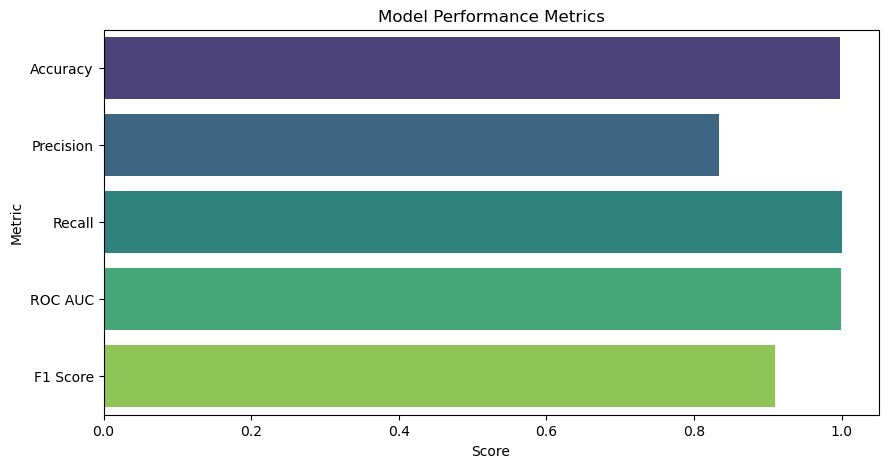

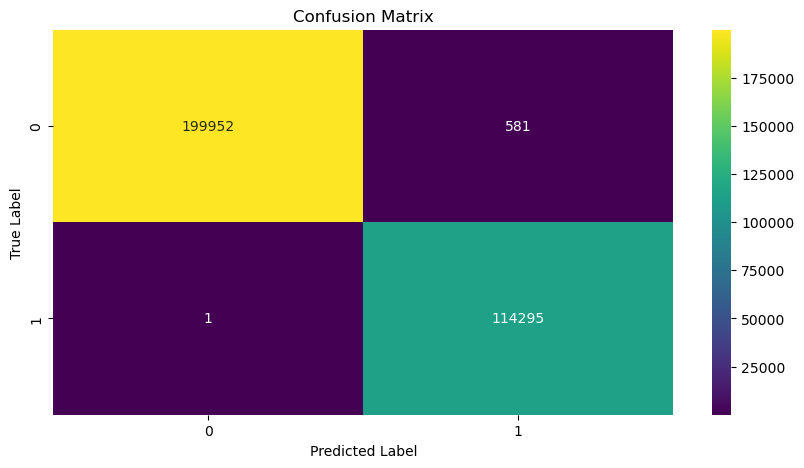

In [ ]:
##1st student name: Philip Acquaye-Mensah
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, DoubleType
import matplotlib.pyplot as plt
import seaborn as sns

# Start Spark session
spark = SparkSession.builder.appName("Model Metrics").getOrCreate()

# Define the schema for the DataFrame explicitly
schema = StructType([
    StructField("Metric", StringType(), True),
    StructField("Score", DoubleType(), True)
])

# Assuming 'metrics' contains float64 types, convert them to float (Python native type)
metrics = [float(accuracy), float(precision), float(recall), float(roc_auc), float(f1)]
metric_names = ["Accuracy", "Precision", "Recall", "ROC AUC", "F1 Score"]
results = list(zip(metric_names, metrics))

# Create DataFrame using the defined schema
results_df = spark.createDataFrame(results, schema)

# Convert to Pandas DataFrame for visualization
results_df_pd = results_df.toPandas()

# Plot the results
plt.figure(figsize=(10, 5))
sns.barplot(x="Score", y="Metric", data=results_df_pd, palette="viridis")
plt.title("Model Performance Metrics")
plt.xlabel("Score")
plt.ylabel("Metric")
plt.show()

# Visualize the confusion matrix
# Note: Ensure ConfusionMatrix is properly defined, e.g., a 2D array or a properly formatted DataFrame
plt.figure(figsize=(10, 5))
sns.heatmap(ConfusionMatrix, annot=True, cmap="viridis", fmt="d")  # ConfusionMatrix needs to be defined
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()




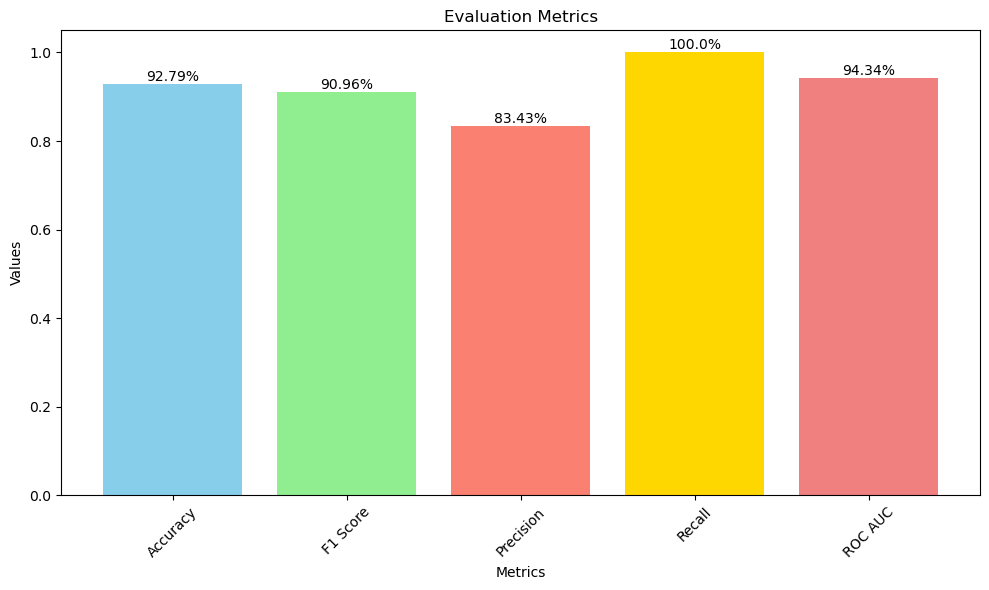

In [ ]:
# 2nd student name: Mohamed Jareer Mohamed Zeenam

import matplotlib.pyplot as plt

# Define evaluation metrics and values
metrics = ['Accuracy', 'F1 Score', 'Precision', 'Recall', 'ROC AUC']
values = [acc, f1, precision, recall, auc]

# Define colors for the bars
colors = ['skyblue', 'lightgreen', 'salmon', 'gold', 'lightcoral']

# Create a bar plot with custom styling
plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color=colors)

# Add labels and title
plt.title('Evaluation Metrics')
plt.xlabel('Metrics')
plt.ylabel('Values')

# Add text labels on top of the bars
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),  f'{round(value * 100, 2)}%',
             ha='center', va='bottom')

# Show plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


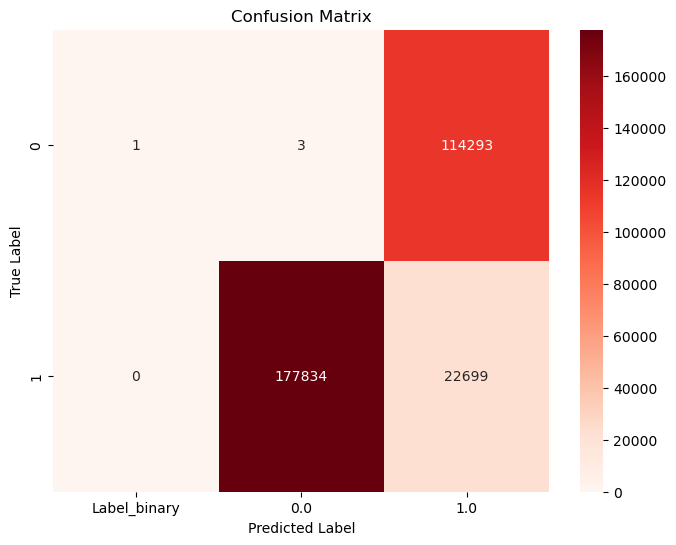

In [ ]:
# 2nd student name: Mohamed Jareer Mohamed Zeenam

import seaborn as sns

# Convert confusion matrix to pandas DataFrame
confusion_matrix_pd = confusion_matrix.toPandas()

# Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_pd, annot=True, cmap='Reds', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


---
# **Task 6 - LSEP Considerations (5 marks)**
---

# Student 1: **Type the chosen issue**

Issue: Bias and Fairness.

Models trained on network traffic data might inadvertently learn to identify benign activities as malicious (false positives) or vice versa (false negatives), particularly if the training data is not representative of all types of network behaviors. 

Mitigation: Utilise a diverse dataset that covers various types of network behaviors to train the model. Regularly validate the model against a diverse test set to ensure that it does not exhibit biased behavior.

# Student 2: **Transparency and Accountability**

Machine learning models trained on network traffic data might be difficult to interpret, making it challenging to understand how they make decisions. This lack of transparency can make it difficult to identify and correct errors or biases in the model.

**Mitigation:** Utilize interpretable machine learning models such as decision trees or linear models that provide insight into how the model makes decisions. Regularly audit the model to ensure that it is making decisions in a transparent and accountable manner.

---

# **Task 7 - Convert ipynb to HTML for Turnitin submission [5 marks]**

---



In [ ]:
# install nbconvert (if facing the conversion error)
# !pip3 install nbconvert

In [ ]:
# convert ipynb to html and submit this HTML file
# !jupyter nbconvert --to html Group_ID_13_CRWK_CN7030.ipynb

[NbConvertApp] Converting notebook Group_ID_13_CRWK_CN7030.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 4 image(s).
[NbConvertApp] Writing 619388 bytes to Group_ID_13_CRWK_CN7030.html
